Import libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os

Reads the data and display the frist 5 rows.

In [2]:
data = pd.read_csv("/workspaces/CS_Group_09_Salary_prediction/data/Salary_Data.csv")

In [3]:
data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


After loading the dataset I am planning to ready the dataset for the training.\

Let start by data exploration to filter out missing and incorrect data.

In [4]:
print("Missing values:\n", data.isnull().sum())

Missing values:
 Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


Lets get the general idea of the dataset by retreiving simple stats by simple calculations of the dataset

In [5]:
print("\nData types:\n", data.dtypes)
print("\nStatistics:\n", data.describe())


Data types:
 Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object

Statistics:
                Age  Years of Experience         Salary
count  6702.000000          6701.000000    6699.000000
mean     33.620859             8.094687  115326.964771
std       7.614633             6.059003   52786.183911
min      21.000000             0.000000     350.000000
25%      28.000000             3.000000   70000.000000
50%      32.000000             7.000000  115000.000000
75%      38.000000            12.000000  160000.000000
max      62.000000            34.000000  250000.000000


Next lets remove the missing raws. Drop any raw with missing values

In [6]:
data_cleaned = data.dropna()

So raws with missing values are romoved now it's the time to take down values that are not natural. Here in this case what I see are Age, Years of Experience, Salary columns. Since Age is not a major fact used in this training I will only consider Years of Experience and Salary columns. All the raws where Years of Experience and salary is 0 or a negative value that should be removed.

In [7]:
data_cleaned = data_cleaned[
    (data_cleaned['Years of Experience'] > 0) & (data_cleaned['Salary'] > 0)
]

Lets checked the removed raws and updated stats of the dataset

In [8]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6578 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6578 non-null   float64
 1   Gender               6578 non-null   object 
 2   Education Level      6578 non-null   object 
 3   Job Title            6578 non-null   object 
 4   Years of Experience  6578 non-null   float64
 5   Salary               6578 non-null   float64
dtypes: float64(3), object(3)
memory usage: 359.7+ KB


In [9]:
data_cleaned.describe()

,Age,Years of Experience,Salary
count,6578.000000,6578.000000,6578.000000
mean,33.811493,8.242855,116891.716175
std,7.553069,6.014961,51957.786817
min,22.000000,0.500000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,119000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


Lets see a side by side coparison of the dataset before and after the cleaning

In [10]:
# Original dataset
raw_desc = data.describe().T

# Cleaned dataset
cleaned_desc = data_cleaned.describe().T

# Rename the columns for better understanding
raw_desc.columns = ['Raw_Count', 'Raw_Mean', 'Raw_Std', 'Raw_Min', 'Raw_25%', 'Raw_50%', 'Raw_75%', 'Raw_Max']
cleaned_desc.columns = ['Cleaned_Count', 'Cleaned_Mean', 'Cleaned_Std', 'Cleaned_Min', 'Cleaned_25%', 'Cleaned_50%', 'Cleaned_75%', 'Cleaned_Max']

# Combine side by side to get a clear view 
comparison_df = pd.concat([raw_desc, cleaned_desc], axis=1)

# Display the tables
comparison_df


,Raw_Count,Raw_Mean,Raw_Std,Raw_Min,Raw_25%,Raw_50%,Raw_75%,Raw_Max,Cleaned_Count,Cleaned_Mean,Cleaned_Std,Cleaned_Min,Cleaned_25%,Cleaned_50%,Cleaned_75%,Cleaned_Max
Age,6702.0,33.620859,7.614633,21.0,28.0,32.0,38.0,62.0,6578.0,33.811493,7.553069,22.0,28.0,32.0,38.0,62.0
Years of Experience,6701.0,8.094687,6.059003,0.0,3.0,7.0,12.0,34.0,6578.0,8.242855,6.014961,0.5,3.0,7.0,12.0,34.0
Salary,6699.0,115326.964771,52786.183911,350.0,70000.0,115000.0,160000.0,250000.0,6578.0,116891.716175,51957.786817,350.0,70000.0,119000.0,160000.0,250000.0


Nex we are going to scale the data. It is a very important step befor applying Lasso regression.
Why? 
Lasso regression depends on feature magnitude. Scaling ensures fair weight distribution amomg the dataset.

In [11]:
from sklearn.preprocessing import StandardScaler

X = data_cleaned[['Years of Experience']]
y = data_cleaned['Salary']

# Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Before traing the dataset it is split in 20% and 80%, 80% training the dataset and remaining 20% to do the testing. We do this because we need to train in a idfferent part adn test in another part. Becasue if we do the train and test in the same part of the dataset it will always give very accurate answers which is missleading because the model might have already memorized the answers which leads to overfiting.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Hyperparameters are external settings that control how the model learns. For lasso regression it uses the 'Alpha' value. 'Alpha' value controls how much the model penalizes large coefficients. 

Alpha value is too high => model underfits.
Alpha value is too low => model overfits.

Need to find the right Alpha value.
Following code is used to automaticaly find the best alpha value of this training prcess. 

In [13]:
from sklearn.linear_model import LassoCV

# Automatically find best alpha using cross-validation
lasso_cv = LassoCV(alphas=np.linspace(0.001, 1, 100), cv=5)
lasso_cv.fit(X_train, y_train)

print(f"Best alpha: {lasso_cv.alpha_}")

Best alpha: 1.0


So after the Alpha value is found next is t train the model.

In [14]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

lasso = Lasso(alpha=lasso_cv.alpha_)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 952897969.69
R² Score: 0.65


finaly display the results. 

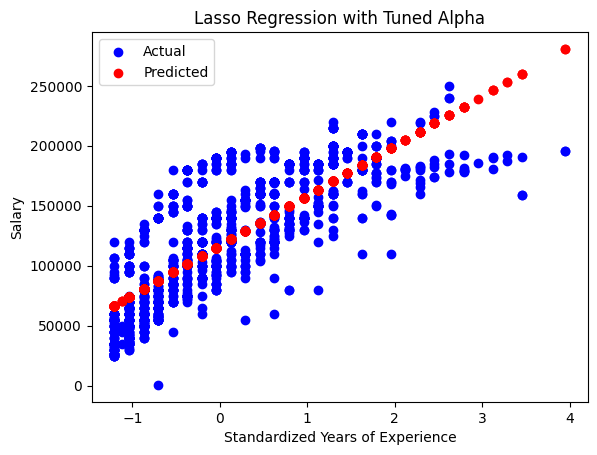

In [15]:
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Standardized Years of Experience')
plt.ylabel('Salary')
plt.title('Lasso Regression with Tuned Alpha')
plt.legend()
plt.show()

After this I am planning to improve the model more. For this next i'll implement cross-validation. So here data is tested on a deferent subset of the training data. For this purpose I use 5-fold validation which features deviding the dataset into 5 and using one potion for testing and other four for training and this is repeated five times where each portion for testing is only used once.

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

# Use the Alpha value found earlier
lasso = Lasso(alpha=lasso_cv.alpha_)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(lasso, X_scaled, y, cv=5, scoring='r2')

print("Cross-Validation R² scores:", cv_scores)
print("Average R² score:", cv_scores.mean())

Cross-Validation R² scores: [-0.4141944   0.68001793  0.67310373  0.72267392  0.77292419]
Average R² score: 0.48690507565984903


Next Residual Analysis is used to identify the differences between the observed values and the predicted values of a model with the purpose of assessing the model's performance and identify potential issues(ex: any consistent errors or patterns) of the model.

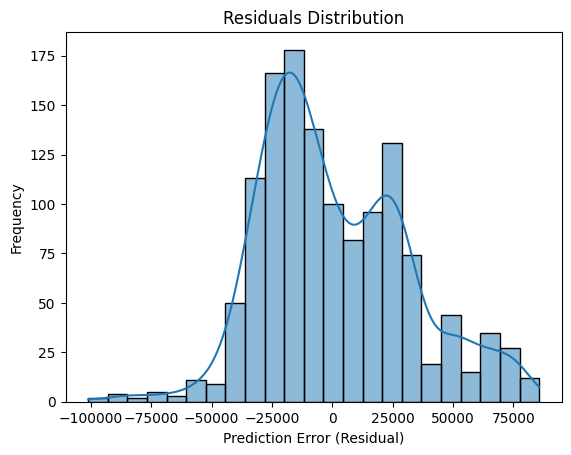

In [17]:
import seaborn as sns

# Calculate residuals (errors)
residuals = y_test - y_pred

# Plot residual distribution
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.show()

What it shows
- Roughly bell shaped. which is good
- It is slightly skewed left: More often overpredicts salary
- Longer tail on the negative side: Some under-predictions.
- There are some outliers (on or after ±75,000)

Conclusion
- Mostly centered which is good but slight skew suggests bias in some salary ranges
- this is in acceptible range but considering the fact that Lasso regression does not consider non-linear relationship this can be improved.

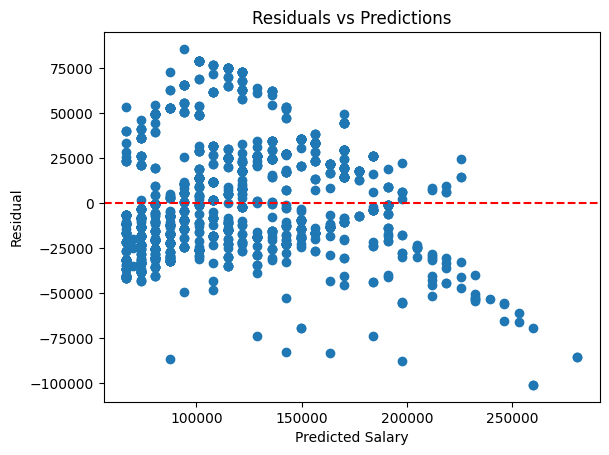

In [18]:

import matplotlib.pyplot as plt

# Scatter residuals vs predicted values
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted Salary")
plt.ylabel("Residual")
plt.show()

What it shows
- Heteroscedasticity: The model’s error increases for higher salaries
- Slight downward slope: Model tends to underpredict high salaries, overpredict low salaries

Conclusion
- Since this model not carture linearity of the data this can't exactly predict correct salary
- Lasso regression is not enought. Should add non-linear models with the comparrison.

Next we will use Grid-search with cross-validation to try multiple alpha values and feature combinations and come up with the more riliable model.
Grid-search: Hyperparameter tuning technique that systematically searches for the best set of hyperparameters for a model by evaluating all possible combinations within a predefined grid.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Build a pipeline: poly features → scale → Lasso
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Define grid search parameters
param_grid = {
    'poly__degree': [1, 2],  # Degree 1 (linear), 2 (quadratic)
    'lasso__alpha': [0.001, 0.01, 0.1, 1.0]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'lasso__alpha': 0.001, 'poly__degree': 2}


So now we retrain the model using the Alpha value got from the Grid search. 

In [20]:
# Reuse the best model
best_model = grid_search.best_estimator_

# Split data again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
best_model.fit(X_train, y_train)

# Predict
y_pred = best_model.predict(X_test)

Now let's display the last results of our enhanced model.

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Model Mean Squared Error: {mse:.2f}")
print(f"Final Model R² Score: {r2:.2f}")

Final Model Mean Squared Error: 774879223.20
Final Model R² Score: 0.71


Compared to the prvious values

Mean Squared Error: 952897969.69
R² Score: 0.65

new model mean is lower and R² Score is near to 70% which shows that the new model is more reliable than the old one.

Visualizing of the final result

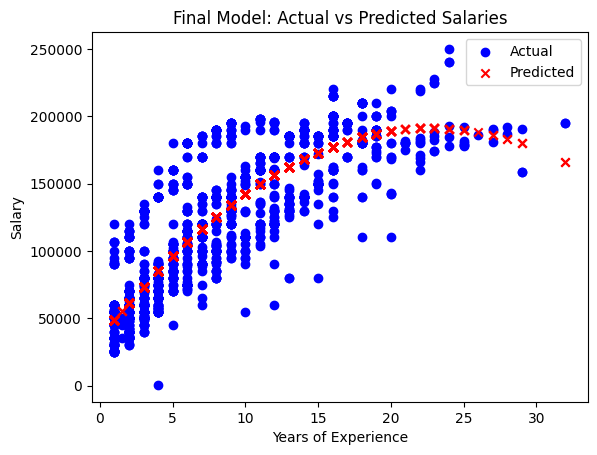

In [22]:
plt.scatter(X_test["Years of Experience"], y_test, color='blue', label='Actual')
plt.scatter(X_test["Years of Experience"], y_pred, color='red', label='Predicted', marker='x')
plt.title("Final Model: Actual vs Predicted Salaries")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.legend()
plt.show()